# Parse TTL from VP output

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import glob
import os
import re

## Dataset directory

In [14]:
dataset_dir = "dataset1/"
dataset_path = os.path.join(os.getcwd(), dataset_dir)  #Specify the full path

In [18]:
# list available files
available_files =  []
for file in os.listdir(dataset_path):
#     if re.match(r"verfploeter_all_20[0-9]+.*\.csv.*", file):
    if re.match(r".*\.csv.*", file):
#     if re.match(r"FROM.*[0-9]+.*\.csv.*", file):

        available_files.append(file)      
available_files      

['FROM-ALL-bgp-us-was-anycast01-2019-06-05-08:00:01.csv.gz']

## remove inconsistency and add timestamp field (normalized)

In [19]:
def check_metadata_from_df(df):
    
    # clean measurement
    df['timestamp'] =  df['transmit_time'].min()
    # remove inconsistency
    df = df[df['destination_address'] == df['meta_source_address']]
    df = df[df['source_address'] == df['meta_destination_address']]
    df.drop_duplicates(keep='last', inplace=False)
     
    return (df)

# 1. TTL distribution 

### prepare the Dataframe by adding missing values

In [20]:
def normalize_ttl_values(df):
    
    # get the current date 
    data=df.groupby('ttl').size().reset_index().rename(columns={0:'count'})
    
    # create an empty dataframe with all the possible values
    df_aux = pd.DataFrame({
                         'ttl' : range(0,256,1),
                         'count' : [0]*256,
                        })
    df_aux.set_index("ttl",inplace=True)
    for index, row in data.iterrows():
        # fill the values with the respective values 
        # keep other values to "0"
        df_aux.loc[row['ttl'],'count']=row['count']
    return (df_aux)

## build TTL graph distribution for a dataframe

In [21]:
def plot_ttl_graph(df):
    
        fig = plt.figure(figsize=(8, 4))
        ax = plt.subplot2grid((1,1), (0,0))

        df.plot(ax=ax,
                fontsize=12,
                legend=False,
                kind="bar")

        ax.set_xlabel('TTL value')
        ax.xaxis.label.set_color('black')
        ax.set_ylabel('# total of packets')
        ax.xaxis.set_tick_params(labelsize=12)
        
        fig.tight_layout();

        ax.tick_params(colors='black')
        xlabels = ax.get_xticklabels()
        xticks = ax.get_xticks()

        frequency = 10
        ax.set_xticklabels(xlabels[::frequency], rotation=45);
        ax.set_xticks(xticks[::frequency]);
        ax.set_ylim(0,320000)
        
        return (ax)

In [24]:
file = dataset_path+available_files[0]
print (file)
df = pd.read_csv(file, sep=",", low_memory=False, index_col=False)

/Users/joaoceron/work/SAND/verfploeter-measurements-ttl/dataset1/FROM-ALL-bgp-us-was-anycast01-2019-06-05-08:00:01.csv.gz


In [23]:
df.columns

Index(['task_id', 'client_id', 'transmit_time', 'receive_time',
       'send_receive_time_diff', 'source_address', 'destination_address',
       'meta_source_address', 'meta_destination_address', 'ttl',
       'source_address_country', 'source_address_asn'],
      dtype='object')

In [25]:
df.head()

,task_id,client_id,transmit_time,receive_time,send_receive_time_diff,source_address,destination_address,meta_source_address,meta_destination_address,ttl,source_address_country,source_address_asn
0,453,us-was-anycast01,1559714494672008475,1559714494674976900,2.968425,1.0.0.230,145.90.8.1,145.90.8.1,1.0.0.230,58,AU,13335
1,453,us-was-anycast01,1559714494675763142,1559714494678682196,2.919054,1.1.1.2,145.90.8.1,145.90.8.1,1.1.1.2,58,AU,13335
2,453,us-was-anycast01,1559714494761378802,1559714494840357796,78.978994,1.39.8.255,145.90.8.1,145.90.8.1,1.39.8.255,55,IN,38266
3,453,us-was-anycast01,1559714494675960918,1559714494844949713,168.988795,1.1.78.1,145.90.8.1,145.90.8.1,1.1.78.1,52,JP,2519
4,453,us-was-anycast01,1559714494676298496,1559714494845082764,168.784268,1.1.126.38,145.90.8.1,145.90.8.1,1.1.126.38,53,JP,2519


## print the TTL distribution for all the days

FROM-ALL-bgp-us-was-anycast01-2019-06-05-08:00:01.csv.gz
1/1


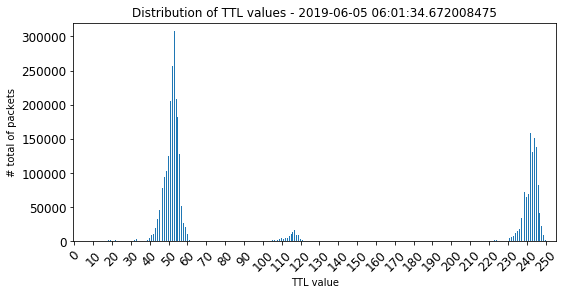

In [27]:
def ttl_distribution(available_files):
  
    count = 0
    for file in available_files:
        print (file)
        count = count +1 
        print ("{}/{}".format(count,len(available_files)))
        file = dataset_path+file
        df = pd.read_csv(file, sep=",", low_memory=False, index_col=False)
        
        df = check_metadata_from_df(df)
        date = pd.to_datetime(df.iloc[0]['timestamp'], unit='ns')
        
        df = normalize_ttl_values(df)
        ax = plot_ttl_graph(df)
        title = "Distribution of TTL values - {}".format(date)
        ax.set_title(title)
        
        filename = "{}../imgs/ttl-distribution-day-{}.png".format(dataset_path, count)
        plt.savefig(filename, dpi=100)
        plt.show();

ttl_distribution(available_files)

In [67]:
!convert -delay 15 -loop 0 $dataset_path/../imgs/ttl-distribution-day-*.png $dataset_path/../imgs/ttl-distribution.gif

---
# 2. TTL cluster distribution

> Assumption:  Internet path does not exceed 30 hops <br>
> https://subinsb.com/default-device-ttl-values/

~~~
group A: 02-32
group B: 34-64
group C: 98-128
group D: 225-255
group E: remain
~~~



## 2.1 Classify the dataframe based on the groups

 ### A. Groups definition

In [78]:
def group_name(row):
    ttl = int(row['ttl'])
    if ( ttl >= 1 and ttl <= 32):
        return ("01-32")
    elif (ttl >= 33 and ttl <= 64):
        return ("33-64")
    elif (ttl >= 97 and ttl <= 128):
        return ("97-128")
    elif (ttl >= 224 and ttl <= 255):
        return ("224-255")
    else:
        return ("remain")

In [79]:
def plot_ttl_group_graph(df):
    
        fig = plt.figure(figsize=(8, 4))
        ax = plt.subplot2grid((1,1), (0,0))

        df.plot(ax=ax,
                fontsize=12,
                legend=False,
                kind="bar")

        ax.set_xlabel('TTL value range')
        ax.xaxis.label.set_color('black')
        ax.set_ylabel('# total of packets')
        ax.xaxis.set_tick_params(labelsize=12)
        
        fig.tight_layout();
        
        ax.tick_params(colors='black')
        xlabels = ax.get_xticklabels()
        ax.set_xticklabels(xlabels, rotation=0)
          
        return (ax)

### B. TTL aggregation by defined groups

In [80]:
def set_groups(available_files):
  
    appended_data = pd.DataFrame()
    count = 0
    for file in available_files:
        print (file)
        count = count +1 
        file = dataset_path+file
        df = pd.read_csv(file, sep=",", index_col=False,low_memory=False)
        
        df = check_metadata_from_df(df)
        date = pd.to_datetime(df.iloc[0]['timestamp'], unit='ns')    
        
        # set groups
        df['group'] = df.apply(group_name, axis=1)
        
        # get stats 
        data = df['group'].value_counts().reset_index()
        
        # custom sort 
        data['index'] = pd.Categorical(data['index'], ["01-32", "33-64", "97-128","224-255","remain"])
        data.sort_values('index',inplace=True)
        data.set_index('index',inplace=True)
        
        # timestamp for this dataset
        data['timestamp'] = df.iloc[0]['timestamp']
        df = data
        appended_data = pd.concat([appended_data, df])
        
    return (appended_data)

df = set_groups(available_files)

# save
file = dataset_path+"verfploeter-ttl-groups.csv"
df.to_csv(file)
df.head()

verfploeter_all_2019-04-26-14:00.csv
verfploeter_all_2019-05-01-14:00.csv
verfploeter_all_2019-03-20-14:00.csv
verfploeter_all_2019-03-22-12:51.csv
verfploeter_all_2019-03-19-14:00.csv
verfploeter_all_2019-03-14-14:00.csv
verfploeter_all_2019-03-21-14:00.csv
verfploeter_all_2019-04-11-14:00.csv
verfploeter_all_2019-04-24-14:00.csv
verfploeter_all_2019-03-17-14:00.csv
verfploeter_all_2019-04-25-14:00.csv
verfploeter_all_2019-04-23-14:00.csv
verfploeter_all_2019-04-16-14:00.csv
verfploeter_all_2019-03-16-14:00.csv


,group,timestamp
index,,
01-32,13331,1501866715
33-64,2040760,1501866715
97-128,116399,1501866715
224-255,1121942,1501866715
remain,2723,1501866715


load results to dataframe (flexibility to run the experiment)

In [82]:
file = dataset_path+"verfploeter-ttl-groups.csv"
df = pd.read_csv(file, sep=",", index_col=False,low_memory=False)
df.set_index('timestamp',inplace=True)
df = df.reset_index()


In [83]:
df.head()

,timestamp,index,group
0,1501866715,01-32,13331
1,1501866715,33-64,2040760
2,1501866715,97-128,116399
3,1501866715,224-255,1121942
4,1501866715,remain,2723


In [84]:
# reshape the dataframe
df = df.pivot(index='timestamp', columns='index')
df.index.name = None

df.columns=df.columns.get_level_values(1)
df.columns.name = None
df.sort_index(inplace=True)

df.head()

,01-32,224-255,33-64,97-128,remain
1501866715,13331,1121942,2040760,116399,2723
1552568426,14565,1150838,2099543,118566,2575
1552741231,13969,1135037,2063483,116019,2571
1552827628,14406,1168525,2106781,148925,2656
1553000428,14468,1159312,2097306,213531,2666


---

# <center>TTL groups stability graphs</center>
---

## 1. TTL groups stability over time

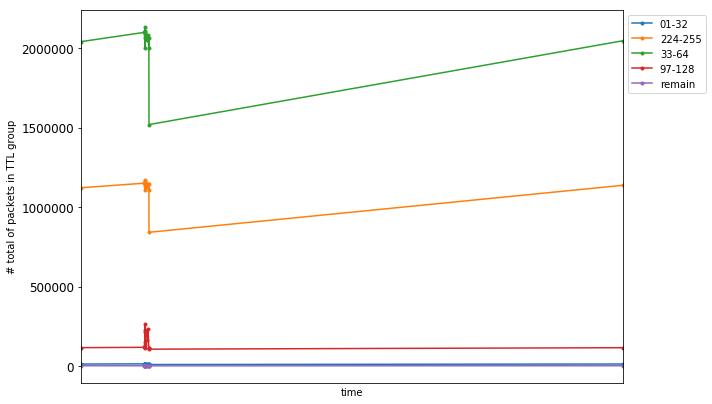

In [85]:
if (len(available_files) < 2):
    print ("you cannot print the stability based on 1 file")
else:

    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot2grid((1,1), (0,0))

    df.plot(ax=ax,
            style='.-',
            fontsize=12,
            legend=True,
            )

    ax.set_xlabel('time')
    ax.xaxis.label.set_color('black')
    ax.set_ylabel('# total of packets in TTL group')
    ax.xaxis.set_tick_params(labelsize=12)
    ax.legend(bbox_to_anchor=(1, 1))
    fig.tight_layout();
    ax.tick_params(colors='black')
    ax.set_xticklabels([], rotation=45);
    ax.set_xticks([])

## 2. TTL groups variability over time

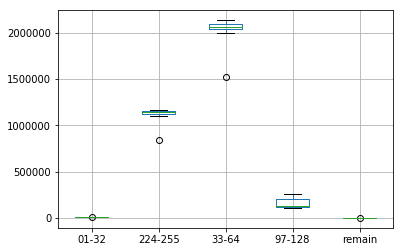

In [86]:
df.boxplot()

## 3. TTL groups composition over time

verfploeter_all_2019-04-26-14:00.csv
1/14


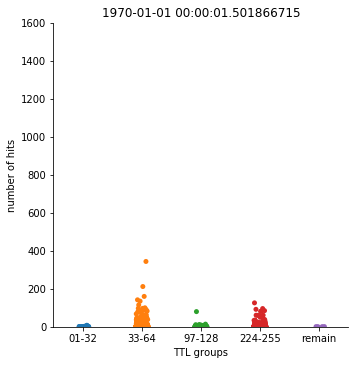

verfploeter_all_2019-05-01-14:00.csv
2/14


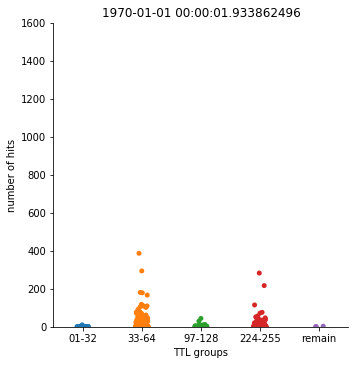

verfploeter_all_2019-03-20-14:00.csv
3/14


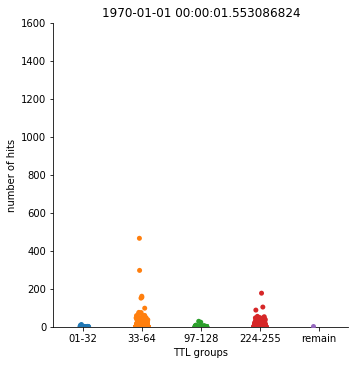

verfploeter_all_2019-03-22-12:51.csv
4/14


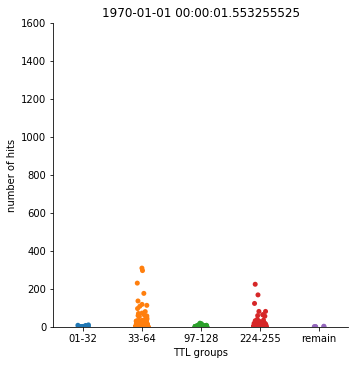

verfploeter_all_2019-03-19-14:00.csv
5/14


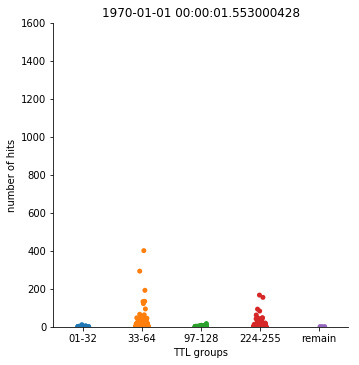

verfploeter_all_2019-03-14-14:00.csv
6/14


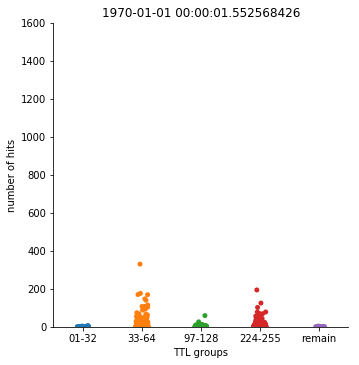

verfploeter_all_2019-03-21-14:00.csv
7/14


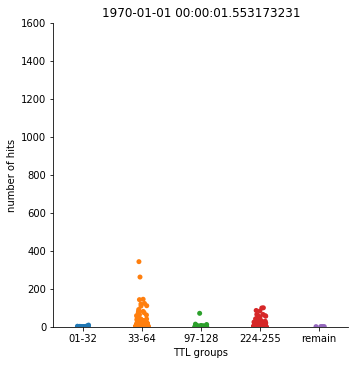

verfploeter_all_2019-04-11-14:00.csv
8/14


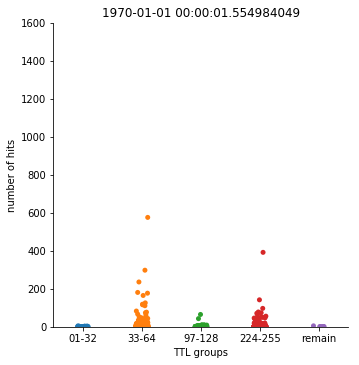

verfploeter_all_2019-04-24-14:00.csv
9/14


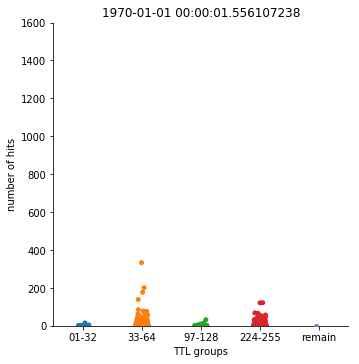

verfploeter_all_2019-03-17-14:00.csv
10/14


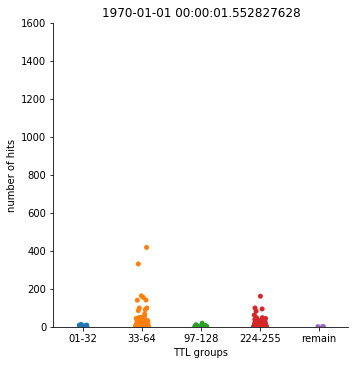

verfploeter_all_2019-04-25-14:00.csv
11/14


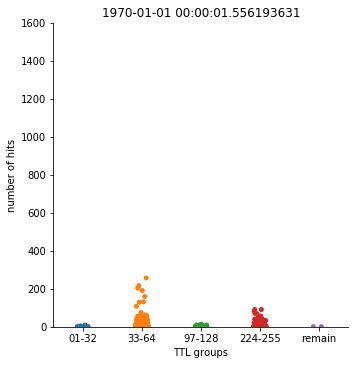

verfploeter_all_2019-04-23-14:00.csv
12/14


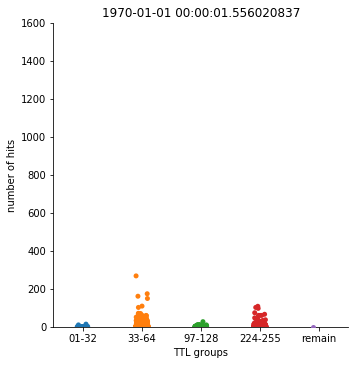

verfploeter_all_2019-04-16-14:00.csv
13/14


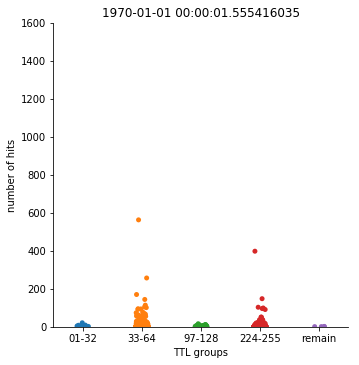

verfploeter_all_2019-03-16-14:00.csv
14/14


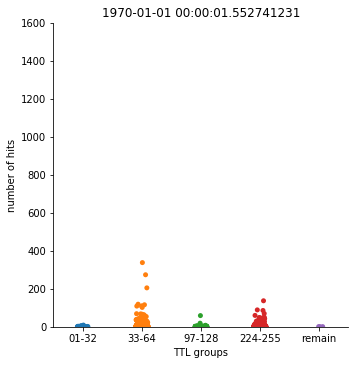

In [88]:
def group_ttl_distribution(available_files):
  
    count = 0
    for file in available_files:
        print (file)
        count = count +1 
        print ("{}/{}".format(count,len(available_files)))
        file = dataset_path+file
        df = pd.read_csv(file, sep=",", index_col=False, nrows=10000)
        
        df = check_metadata_from_df(df)
        date = pd.to_datetime(df.iloc[0]['timestamp'], unit='ns')
        
        # set groups
        df['group'] = df.apply(group_name, axis=1)
        
        df_aux = df.groupby(['source_address_asn','source_address_country','group','client_id'])\
    .size().reset_index().rename(columns={0:'count'})
               
        ax = sns.catplot(x="group", y="count", data=df_aux, order =["01-32", "33-64", "97-128","224-255","remain"] );
        title = "{}".format(date)
        ax.set(xlabel='TTL groups', ylabel='number of hits', title=title)
        ax.set(ylim=(0, 1600))
        filename = "{}../imgs/{}-ttl-group.png".format(dataset_path, count)
        plt.savefig(filename, dpi=100)
        plt.show();


group_ttl_distribution(available_files)

In [89]:
!convert -delay 15 -loop 0 $dataset_path/../imgs/*-group.png $dataset_path/../imgs/ttl.gif


---
# <center> Group `remain` investigation graphs </center>
---

### A. Build dataframe using the `remain` group from all the files (over time)

In [92]:
def remain_ttl_group(available_files):
  
    count = 0
    appended_data = pd.DataFrame()
    for file in available_files:
        print (file)
        count = count +1 
        print ("{}/{}".format(count,len(available_files)))
        file = dataset_path+file
        df = pd.read_csv(file, sep=",", index_col=False, low_memory=False)

        df = check_metadata_from_df(df)
        date = pd.to_datetime(df.iloc[0]['timestamp'], unit='ns')
        print (df.iloc[0]['timestamp'])
        # set groups
        df['group'] = df.apply(group_name, axis=1)
        df = df[df['group'] == "remain"]
        df = df[['source_address_asn', 'source_address', 'source_address_country', 'ttl', 'group','client_id','timestamp']]
        appended_data = pd.concat([appended_data, df])
        
    return (appended_data)

df = remain_ttl_group(available_files)
file = dataset_path+"verfploeter-ttl-remain-group-all.csv"
df.to_csv(file)

verfploeter_all_2019-04-26-14:00.csv
1/14


KeyboardInterrupt: 

Load dataframe 

In [94]:
file = dataset_path+"verfploeter-ttl-remain-group-all.csv"
df_ttl_remains = pd.read_csv(file, index_col=False)
len(df_ttl_remains)

1826

### B. TTL value distribution 

Text(0.5,1,'Remain TTLs')

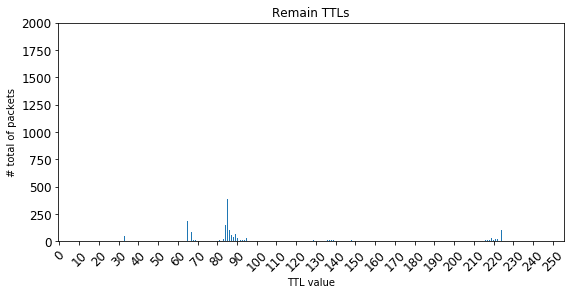

In [96]:
df = normalize_ttl_values(df_ttl_remains)
ax = plot_ttl_graph(df)
ax.set_ylim(0,2000)
ax.set_title("Remain TTLs")

In [48]:
# df_ttl_remains['node'] = df_ttl_remains['client_id'] + " - " + df_ttl_remains['source_address_country']
# df_aux = top_n_dataframe(10,df_ttl_remains['node']).reset_index()
# ax = sns.catplot(y="percent", x="node", kind="bar",  data=df_aux);
# ax.set(xlabel='', ylabel='percent (%)', title="")
# ax.set_xticklabels(rotation=90)
# df_aux

In [49]:
def top_n_dataframe(n,dataframe_field):
    
    top_n = n
    field_name = dataframe_field.name
    top  = dataframe_field.value_counts()[:top_n].to_frame().reset_index()

    new_row = pd.DataFrame(data = {
        'hits' : [ dataframe_field.value_counts()[top_n:].sum()],
        field_name : ['others'],
    })

    top.columns = [field_name, 'hits']
    top.set_index([field_name]).reset_index()
    top_result = pd.concat([top, new_row], sort=True)
    
    # percentage field
    df = top_result.groupby(field_name).sum() 
    df=df.sort_values(by="hits", ascending=False)
    df['percent'] = df.transform(lambda x: (x/np.sum(x)*100)) 
    
    return (df)

### C. Src IP country distribution

,node,hits,percent
0,CN,695,38.061336
1,US,630,34.501643
2,others,197,10.788609
3,Unknown,64,3.504929
4,HK,58,3.176342
5,RU,49,2.683461
6,GB,35,1.916758
7,UA,29,1.588171
8,TW,28,1.533406
9,NL,21,1.150055


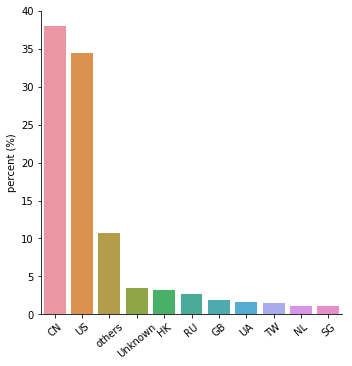

In [50]:
df_ttl_remains['node'] = df_ttl_remains['source_address_country']
df_aux = top_n_dataframe(10,df_ttl_remains['node']).reset_index()
ax = sns.catplot(y="percent", x="node", kind="bar",  data=df_aux);
ax.set(xlabel='', ylabel='percent (%)', title="")
ax.set_xticklabels(rotation=40)
df_aux

### D. Src ASN distribution

,node,hits,percent
0,37963,635,34.775465
1,others,443,24.260679
2,15169,279,15.279299
3,45102,209,11.445783
4,395954,91,4.983571
5,7018,38,2.081051
6,19527,37,2.026287
7,20248,32,1.752464
8,32934,24,1.314348
9,3462,22,1.204819


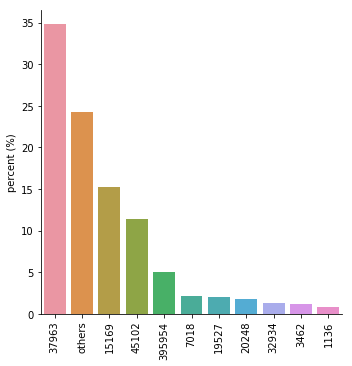

In [51]:
df_ttl_remains['node'] = df_ttl_remains['source_address_asn']
df_aux = top_n_dataframe(10,df_ttl_remains['node']).reset_index()
ax = sns.catplot(y="percent", x="node", kind="bar",  data=df_aux);
ax.set(xlabel='', ylabel='percent (%)', title="")
ax.set_xticklabels(rotation=90)
df_aux

In [32]:
# df_ttl_remains [ df_ttl_remains['source_address_asn'] == "37963"]

### E. Distribution by anycast node

In [33]:
# anycast node distribution
a = df_ttl_remains.groupby(["client_id","source_address_country"]).size().reset_index()
a.head()

,client_id,source_address_country,0
0,au-syd-anycast01,AU,268
1,au-syd-anycast01,BN,13
2,au-syd-anycast01,CN,16576
3,au-syd-anycast01,HK,693
4,au-syd-anycast01,IN,188


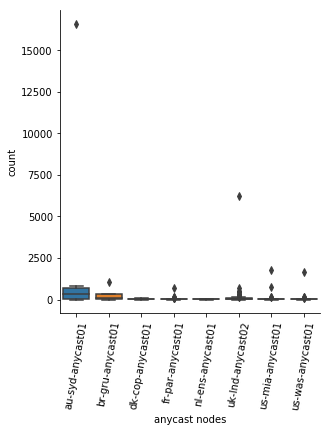

In [34]:
ax = sns.catplot(y=0, x="client_id",  kind="box", data=a);
ax.set(xlabel='anycast nodes', ylabel='count', title="")
ax.set_xticklabels(rotation=80)

